In [ ]:
# Imports
import os, tarfile, re, glob, random
import pickle
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
import seaborn as sns

from tqdm import tqdm
from PIL import Image

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")

In [ ]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

### Data extracting/loading (done)

In [ ]:
# Paths
BASE_DIR = "."
DATA_DIR = os.path.join(BASE_DIR, "data", "UTKFace")
os.makedirs(DATA_DIR, exist_ok=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --quiet torch==2.2.2 torchvision==0.17.2 facenet-pytorch==2.6.0

In [ ]:
GDRIVE_ARCHIVE_BASE_PATH = "/content/drive/MyDrive/UTK"

ARCHIVES = [
    os.path.join(GDRIVE_ARCHIVE_BASE_PATH, "part1.tar.gz"),
    os.path.join(GDRIVE_ARCHIVE_BASE_PATH, "part2.tar.gz"),
    os.path.join(GDRIVE_ARCHIVE_BASE_PATH, "part3.tar.gz"),
]

def safe_extract(tar_path, extract_to):
    with tarfile.open(tar_path, "r:*") as tar:
        for member in tar.getmembers():
            member_path = os.path.join(extract_to, member.name)
            if not os.path.abspath(member_path).startswith(os.path.abspath(extract_to)):
                raise Exception(f"Unsafe path in {tar_path}: {member.name}")
        tar.extractall(extract_to)
    print(f"Extracted {os.path.basename(tar_path)}")

# Idempotent extraction loop
for arc in ARCHIVES:
    flag = os.path.join(DATA_DIR, f".done_{os.path.basename(arc)}")
    if os.path.exists(flag):
        print(f"Already extracted: {os.path.basename(arc)}")
        continue
    if not os.path.exists(arc):
        print(f"Missing archive: {arc}")
        continue
    safe_extract(arc, DATA_DIR)
    open(flag, "w").close()


Missing archive: /content/drive/MyDrive/UTK/part1.tar.gz
Missing archive: /content/drive/MyDrive/UTK/part2.tar.gz
Missing archive: /content/drive/MyDrive/UTK/part3.tar.gz


In [ ]:
# Collect & Parse Metadata
image_paths = sorted(glob.glob(os.path.join(DATA_DIR, "**", "*.jpg"), recursive=True))
print(f"Found {len(image_paths)} images in total.")

def is_valid_image(path):
    try:
        img = Image.open(path)
        img.verify()
        return True
    except:
        return False

def parse_label(path):
    """
    Parse UTKFace filename: age_gender_race_*.jpg
    gender: 0 = male, 1 = female
    race: 0 = White, 1 = Black, 2 = Asian, 3 = Indian, 4 = Others
    """
    name = os.path.basename(path)
    match = re.match(r"(\d+)_(\d+)_(\d+)_", name)
    if not match:
        return None, None, None
    age = int(match.group(1))
    gender = int(match.group(2))
    race = int(match.group(3))
    return age, gender, race

records = []
for p in image_paths:
    if not is_valid_image(p):
        continue
    age, gender, race = parse_label(p)
    if age is None:
        continue
    records.append([p, age, gender, race])

df = pd.DataFrame(records, columns=["path", "age", "gender", "race"])
print("After cleaning:", len(df))
df.head()


Found 0 images in total.
After cleaning: 0


,path,age,gender,race


In [ ]:
!pip install torch==2.0.1 torchvision==0.15.2
!pip install facenet-pytorch==2.5.3

ERROR: Could not find a version that satisfies the requirement torch==2.0.1 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0, 2.9.0, 2.9.1)
ERROR: No matching distribution found for torch==2.0.1
  Using cached facenet_pytorch-2.5.3-py3-none-any.whl.metadata (13 kB)
Using cached facenet_pytorch-2.5.3-py3-none-any.whl (1.9 MB)
  Attempting uninstall: facenet-pytorch
    Found existing installation: facenet-pytorch 2.6.0
    Uninstalling facenet-pytorch-2.6.0:
      Successfully uninstalled facenet-pytorch-2.6.0


In [ ]:
from facenet_pytorch import MTCNN
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# MTCNN face detector
mtcnn = MTCNN(
    image_size=224,   # final face size
    margin=20,        # add a bit of context around face
    post_process=False,
    device=device
)

# Directory where cropped faces will be stored
CROPPED_DIR = "/content/drive/MyDrive/UTK/cropped/UTKFace_cropped"
os.makedirs(CROPPED_DIR, exist_ok=True)

Using device: cuda


In [ ]:
def build_cropped_dataframe(df, batch_size=32, mtcnn_input_size=256):
    """
    Face cropping with MTCNN (single-image, robust).
    - Uses existing global mtcnn and CROPPED_DIR.
    - Reuses already-cropped files.
    - Returns a new df with updated 'path' for successfully cropped images.
    """
    old_to_new = {}
    failed = []

    paths = df["path"].tolist()

    for p in tqdm(paths, desc="Cropping faces (single-image MTCNN)"):
        filename = os.path.basename(p)
        out_path = os.path.join(CROPPED_DIR, filename)

        # If already cropped from a previous run, reuse it
        if os.path.exists(out_path):
            old_to_new[p] = out_path
            continue

        # Load original image
        try:
            img = Image.open(p).convert("RGB")
        except Exception:
            failed.append(p)
            continue

        # Run MTCNN on a single image
        try:
            with torch.no_grad():
                face_tensor = mtcnn(img)
        except Exception:
            failed.append(p)
            continue

        # No face detected
        if face_tensor is None:
            failed.append(p)
            continue

        # Convert tensor -> uint8 PIL
        face_tensor = face_tensor.clamp(0, 255)
        np_img = face_tensor.permute(1, 2, 0).cpu().numpy()
        if np_img.dtype != "uint8":
            np_img = np_img.astype("uint8")

        cropped_img = Image.fromarray(np_img)
        cropped_img.save(out_path)

        old_to_new[p] = out_path

    print(f"\nTotal images: {len(paths)}")
    print(f"Cropped / reused: {len(old_to_new)}")
    print(f"Failed (no face or error): {len(failed)}")

    df_cropped = df[df["path"].isin(old_to_new.keys())].copy()
    df_cropped["path"] = df_cropped["path"].map(old_to_new)

    return df_cropped, failed

In [ ]:
df_cropped, failed_paths = build_cropped_dataframe(df, batch_size=32)

print("Original df:", df.shape)
print("Cropped df:", df_cropped.shape)

Cropping faces (single-image MTCNN): 0it [00:00, ?it/s]


Total images: 0
Cropped / reused: 0
Failed (no face or error): 0
Original df: (0, 4)
Cropped df: (0, 4)


In [ ]:
len([f for f in os.listdir(CROPPED_DIR) if f.lower().endswith(".jpg")])

0

In [ ]:
CROPPED_DIR = "/content/drive/MyDrive/UTK/cropped/UTKFace_cropped"
image_paths = sorted(glob.glob(os.path.join(CROPPED_DIR, "*.jpg")))
print("Found", len(image_paths), "cropped images")

def parse_label(name):
    m = re.match(r"(\d+)_(\d+)_(\d+)_", name)
    if not m:
        return None
    age = int(m.group(1))
    gender = int(m.group(2))
    race = int(m.group(3))
    return age, gender, race

records = []
for p in image_paths:
    fname = os.path.basename(p)
    parsed = parse_label(fname)
    if parsed is None:
        continue
    age, gender, race = parsed
    records.append({"path": p, "age": age, "gender": gender, "race": race})

df_cropped = pd.DataFrame(records)
print(df_cropped.shape)
df_cropped.head()

Found 0 cropped images
(0, 0)


""


In [ ]:
# Age Buckets
# 0–12: 0 (Child)
# 13–19: 1 (Teenager)
# 20–39: 2 (Young Adult)
# 40–59: 3 (Middle-Aged)
# 60+: 4 (Senior)

NUM_AGE_GROUPS = 5
NUM_GENDERS = 2
NUM_RACES = 5

def age_to_group(age):
    if age <= 12:
        return 0
    elif age <= 19:
        return 1
    elif age <= 39:
        return 2
    elif age <= 59:
        return 3
    else:
        return 4

df["age_group"] = df["age"].apply(age_to_group)

In [ ]:
# Map readable gender, race, and age group strings
gender_map = {0: "Male", 1: "Female"}
race_map = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Other"}
age_group_map = {
    0: "Child (0–12)",
    1: "Teen (13–19)",
    2: "Young Adult (20–39)",
    3: "Middle-Aged (40–59)",
    4: "Senior (60+)"
}

df["gender_str"] = df["gender"].map(gender_map)
df["race_str"] = df["race"].map(race_map)
df["age_group_str"] = df["age_group"].map(age_group_map)

In [ ]:
print("Gender distribution:")
print(df["gender_str"].value_counts())

print("\nRace distribution:")
print(df["race_str"].value_counts())

print("\nAge group distribution:")
print(df["age_group_str"].value_counts())

Gender distribution:
Series([], Name: count, dtype: int64)

Race distribution:
Series([], Name: count, dtype: int64)

Age group distribution:
Series([], Name: count, dtype: int64)


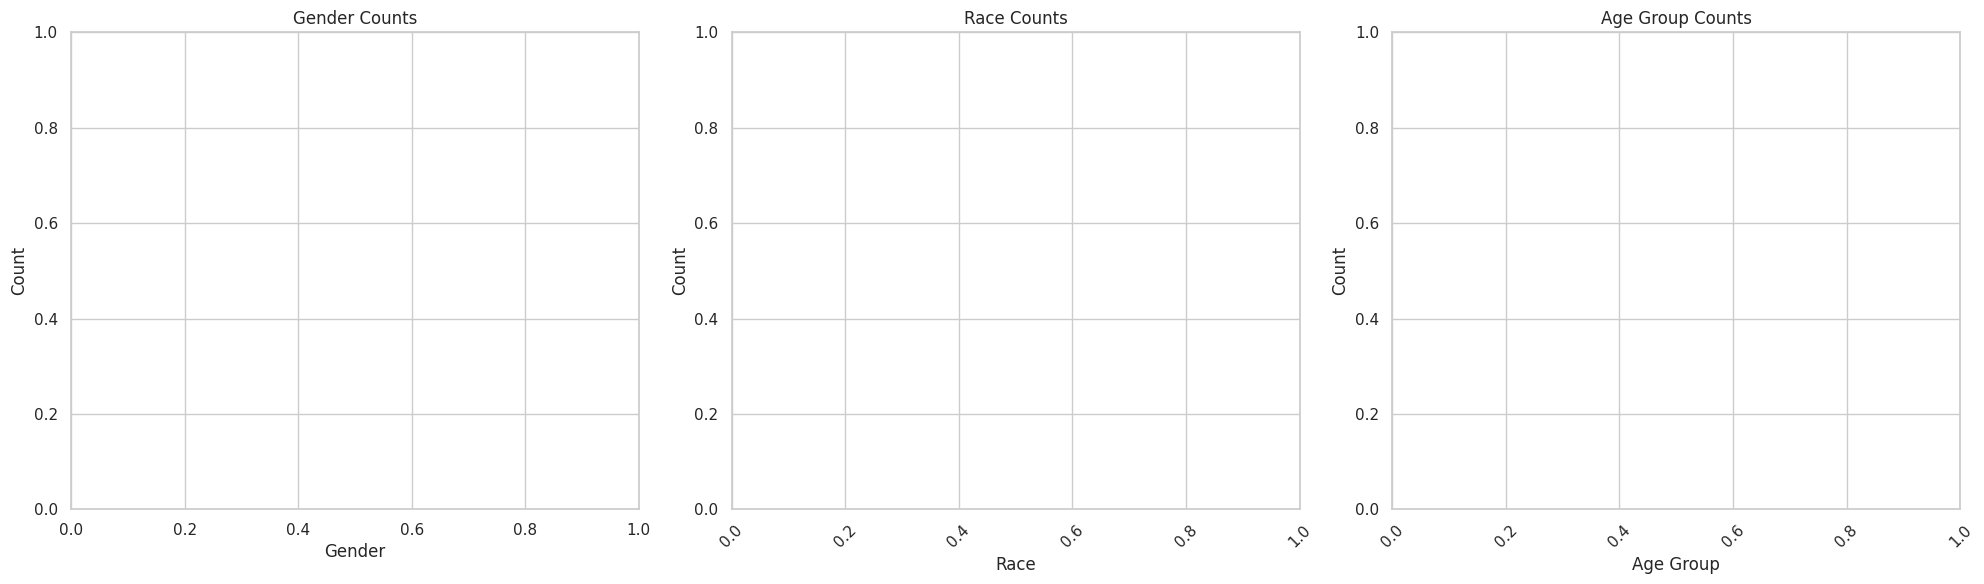

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

sns.countplot(
    data=df,
    x="gender_str",
    order=df["gender_str"].value_counts().index,
    ax=axs[0]
)
axs[0].set_title("Gender Counts")
axs[0].set_xlabel("Gender")
axs[0].set_ylabel("Count")

sns.countplot(
    data=df,
    x="race_str",
    order=df["race_str"].value_counts().index,
    ax=axs[1]
)
axs[1].set_title("Race Counts")
axs[1].set_xlabel("Race")
axs[1].set_ylabel("Count")
axs[1].tick_params(axis='x', rotation=45)

sns.countplot(
    data=df,
    x="age_group_str",
    order=df["age_group_str"].value_counts().index,
    ax=axs[2]
)
axs[2].set_title("Age Group Counts")
axs[2].set_xlabel("Age Group")
axs[2].set_ylabel("Count")
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Stratify by age_group for more balanced splits
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    random_state=SEED,
    stratify=df["age_group"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=SEED,
    stratify=temp_df["age_group"]
)

print(len(train_df), len(val_df), len(test_df))

ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
for name, d in [("train", train_df), ("val", val_df), ("test", test_df)]:
    print(f"\n{name.upper()} distribution:")
    print("Age groups:\n", d["age_group_str"].value_counts())
    print("Gender:\n", d["gender_str"].value_counts())
    print("Race:\n", d["race_str"].value_counts())

### Save splits (this is done):

---



In [ ]:
PICKLE_DIR = "/content/drive/MyDrive/UTK/UTKFace_pickles"
os.makedirs(PICKLE_DIR, exist_ok=True)

with open(os.path.join(PICKLE_DIR, "df_cropped.pkl"), "wb") as f:
    pickle.dump(df_cropped, f)

with open(os.path.join(PICKLE_DIR, "train_df.pkl"), "wb") as f:
    pickle.dump(train_df, f)
with open(os.path.join(PICKLE_DIR, "val_df.pkl"), "wb") as f:
    pickle.dump(val_df, f)
with open(os.path.join(PICKLE_DIR, "test_df.pkl"), "wb") as f:
    pickle.dump(test_df, f)

### Load pickles:

In [ ]:
# START HERE
import requests
GITHUB_BASE = "https://raw.githubusercontent.com/Theflawlessone/Face_Detection/main/pickle_files"

def load_pickle_from_github(filename):
    url = f"{GITHUB_BASE}/{filename}"
    response = requests.get(url)
    response.raise_for_status()  # catch 404 errors
    return pickle.loads(response.content)

In [ ]:
train_df = load_pickle_from_github("train_df.pkl")
val_df   = load_pickle_from_github("val_df.pkl")
test_df  = load_pickle_from_github("test_df.pkl")
df_cropped = load_pickle_from_github("df_cropped.pkl")

# Chacking Dataset columns and ensuring we can access the images

In [ ]:
print(df_cropped.columns)

In [ ]:
sample = df_cropped.sample(9, random_state=42)

plt.figure(figsize=(10,10))
for i, row in enumerate(sample.itertuples(), 1):
    img = Image.open(row.path)
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Age: {row.age}, Gender: {row.gender}")
plt.show()


In [ ]:
age1_df = df_cropped[df_cropped["age"] == 1]

plt.figure(figsize=(12, 12))

for i, row in enumerate(age1_df.tail(16).itertuples(), 1):  # show last 16
    img = Image.open(row.path)
    plt.subplot(4, 4, i)
    plt.imshow(img)
    plt.axis("off")
    gender_label = "Male" if row.gender == 0 else "Female"
    plt.title(f"{gender_label}, Age 1")

plt.show()


# Summary Statistics

In [ ]:
print(df_cropped.describe())

In [ ]:
print("Gender distribution:")
print("0 is male and 1 is female")
print(df_cropped["gender"].value_counts())

In [ ]:
print("Male %:", round(df_cropped[df_cropped.gender==0].shape[0] / len(df) * 100, 2))
print("Female %:", round(df_cropped[df_cropped.gender==1].shape[0] / len(df) * 100, 2))

In [ ]:
print("Age distribution:")
print(df_cropped["age"].value_counts())

In [ ]:
print("AGE 26 perentage:", round(df_cropped[df_cropped.age==26].shape[0] / len(df) * 100, 2))
print("AGE 1 perentage:", round(df_cropped[df_cropped.age==1].shape[0] / len(df) * 100, 2))
print("AGE 28 perentage:", round(df_cropped[df_cropped.age==28].shape[0] / len(df) * 100, 2))

In [ ]:
df_cropped[df_cropped["age"] == 1]["gender"].value_counts()

# Graphs showing skewness/ unbalance

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_cropped, x="gender")
plt.title("Gender Distribution (0 = Male, 1 = Female)")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df_cropped["age"], bins=30, kde=True)
plt.title("Age Distribution in UTKFace Dataset")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

In [ ]:
plt.figure(figsize=(8,3))
sns.boxplot(x=df_cropped["age"])
plt.title("Age Outlier Detection")
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df_cropped, x="gender", y="age")
plt.title("Age Distribution by Gender")
plt.xlabel("Gender (0=Male, 1=Female)")
plt.show()

# Resizing the images and loading into an array

In [ ]:
IMG_SIZE = 224  # for ResNet

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.15, contrast=0.15),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

### CLF

In [ ]:
class UTKFaceDataset(Dataset):
    """
    Flexible dataset:
    - mode = "regression": returns age (float)
    - mode = "age_group": returns age_group (long)
    - mode = "multi": returns both (plus gender, race)
    """
    def __init__(self, df, transform=None, mode="age_group"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img = Image.open(row["path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)

        age = torch.tensor(row["age"], dtype=torch.float32)
        age_group = torch.tensor(row["age_group"], dtype=torch.long)
        gender = torch.tensor(row["gender"], dtype=torch.long)
        race = torch.tensor(row["race"], dtype=torch.long)

        if self.mode == "regression":
            return img, age, gender, race
        elif self.mode == "age_group":
            return img, age_group, gender, race
        else:  # "multi"
            return img, age, age_group, gender, race

In [ ]:
# create dataset objects from the pickle splits
train_df = load_pickle_from_github("train_df.pkl")
val_df   = load_pickle_from_github("val_df.pkl")
test_df  = load_pickle_from_github("test_df.pkl")

In [ ]:
# build datasets
train_ds = UTKFaceDataset(train_df, transform=train_transform, mode="age_group")   # change mode for regressions
val_ds   = UTKFaceDataset(val_df,   transform=test_transform,  mode="age_group")
test_ds  = UTKFaceDataset(test_df,  transform=test_transform, mode="age_group")

In [ ]:
# wrap them in loaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

BATCH_SIZE = 32

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
)

In [ ]:
# sanity check
batch = next(iter(train_loader))
print(len(batch))  # should be 4 for mode="age_group": (img, age_group, gender, race)

imgs, age_group, gender, race = batch
print(imgs.shape)        # [B, 3, 224, 224]
print(age_group.shape)   # [B]
print(gender.shape)      # [B]
print(race.shape)        # [B]

In [ ]:
NUM_AGE_GROUPS = 5  # 0–4

class AgeGroupResNet18(nn.Module):
    def __init__(self, num_age_groups=NUM_AGE_GROUPS):
        super().__init__()
        # Pretrained ResNet-18
        self.base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        in_feats = self.base.fc.in_features
        # Replace final fc with our classifier
        self.base.fc = nn.Linear(in_feats, num_age_groups)

    def forward(self, x):
        return self.base(x)  # logits [B, num_age_groups]

In [ ]:
model = AgeGroupResNet18().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, age_group, gender, race in loader:
        imgs = imgs.to(device)
        age_group = age_group.to(device)

        optimizer.zero_grad()
        logits = model(imgs)           # [B, num_age_groups]
        loss = criterion(logits, age_group)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        _, preds = logits.max(1)
        correct += (preds == age_group).sum().item()
        total += imgs.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc


@torch.no_grad()
def eval_one_epoch(model, loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, age_group, gender, race in loader:
        imgs = imgs.to(device)
        age_group = age_group.to(device)

        logits = model(imgs)
        loss = criterion(logits, age_group)

        running_loss += loss.item() * imgs.size(0)

        _, preds = logits.max(1)
        correct += (preds == age_group).sum().item()
        total += imgs.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

In [ ]:
EPOCHS = 10  # you can bump this once it’s stable
best_val_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = eval_one_epoch(model, val_loader, device)

    print(f"Epoch {epoch:02d}:")
    print(f"  Train - loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"  Val   - loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_agegroup_resnet18.pt")
        print("  ↳ Saved new best model.")

In [ ]:
model.load_state_dict(torch.load("best_agegroup_resnet18.pt", map_location=device))
test_loss, test_acc = eval_one_epoch(model, test_loader, device)
print(f"Test - loss: {test_loss:.4f}, acc: {test_acc:.4f}")

In [ ]:
from collections import defaultdict

@torch.no_grad()
def eval_by_group(model, loader, device):
    model.eval()

    # overall
    total = 0
    correct = 0

    # per gender and race
    gender_correct = defaultdict(int)
    gender_total = defaultdict(int)

    race_correct = defaultdict(int)
    race_total = defaultdict(int)

    # optionally per age_group too
    agegroup_correct = defaultdict(int)
    agegroup_total = defaultdict(int)

    for imgs, age_group, gender, race in loader:
        imgs = imgs.to(device)
        age_group = age_group.to(device)

        logits = model(imgs)
        _, preds = logits.max(1)

        batch_size = imgs.size(0)
        total += batch_size
        correct += (preds == age_group).sum().item()

        # Move meta labels to CPU numpy
        gender_np = gender.cpu().numpy()
        race_np = race.cpu().numpy()
        true_age_np = age_group.cpu().numpy()
        pred_np = preds.cpu().numpy()

        for g, r, t, p in zip(gender_np, race_np, true_age_np, pred_np):
            # gender stats
            gender_total[g] += 1
            if p == t:
                gender_correct[g] += 1

            # race stats
            race_total[r] += 1
            if p == t:
                race_correct[r] += 1

            # age_group stats
            agegroup_total[t] += 1
            if p == t:
                agegroup_correct[t] += 1

    overall_acc = correct / total

    gender_acc = {g: gender_correct[g] / gender_total[g] for g in gender_total}
    race_acc   = {r: race_correct[r] / race_total[r] for r in race_total}
    agegroup_acc = {a: agegroup_correct[a] / agegroup_total[a] for a in agegroup_total}

    return overall_acc, gender_acc, race_acc, agegroup_acc


In [ ]:
@torch.no_grad()
def eval_by_group(model, loader, device):
    model.eval()

    total = 0
    correct = 0

    # stats before mapping (keys are ints)
    gender_correct = defaultdict(int)
    gender_total   = defaultdict(int)

    race_correct = defaultdict(int)
    race_total   = defaultdict(int)

    agegroup_correct = defaultdict(int)
    agegroup_total   = defaultdict(int)

    for imgs, age_group, gender, race in loader:
        imgs = imgs.to(device)
        age_group = age_group.to(device)

        logits = model(imgs)
        _, preds = logits.max(1)

        total += imgs.size(0)
        correct += (preds == age_group).sum().item()

        # move meta labels to CPU
        g_np = gender.cpu().numpy()
        r_np = race.cpu().numpy()
        t_np = age_group.cpu().numpy()
        p_np = preds.cpu().numpy()

        for g, r, t, p in zip(g_np, r_np, t_np, p_np):
            gender_total[g] += 1
            race_total[r] += 1
            agegroup_total[t] += 1

            if p == t:
                gender_correct[g] += 1
                race_correct[r] += 1
                agegroup_correct[t] += 1

    # overall
    overall_acc = correct / total

    # map int keys -> strings
    gender_acc = {
        gender_map[g]: gender_correct[g] / gender_total[g]
        for g in gender_total
    }

    race_acc = {
        race_map[r]: race_correct[r] / race_total[r]
        for r in race_total
    }

    agegroup_acc = {
        age_group_map[a]: agegroup_correct[a] / agegroup_total[a]
        for a in agegroup_total
    }

    return overall_acc, gender_acc, race_acc, agegroup_acc


In [ ]:
overall_acc, gender_acc, race_acc, agegroup_acc = eval_by_group(
    model, test_loader, device
)

print("----Bias & Fairness Evaluation----")
print("Overall Accuracy:", round(overall_acc, 4))
print("\nAccuracy by Gender:")
for k, v in gender_acc.items():
    print(f"  {k}: {v:.4f}")

print("\nAccuracy by Race:")
for k, v in race_acc.items():
    print(f"  {k}: {v:.4f}")

print("\nAccuracy by Age Group (True Labels):")
for k, v in agegroup_acc.items():
    print(f"  {k}: {v:.4f}")
